In [ ]:
import time
import timeit
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from scipy.sparse import diags
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import gmres
import matplotlib.pyplot as plt


# define a custom diagonal matrix, offsets_num determines the number of diagonals, its value should be less than or equal to the matrix size n
# I will next use this function to control the density of the matrix (the number of zeros in the matrix)
def my_diagonal_matrix(offsets_num, n):
    offsets_arr = [0] + list(np.arange(1, offsets_num)) + list(- np.arange(1, offsets_num))
    data = [float(np.random.randn(1)) * np.ones(n - abs(offset)) for offset in offsets_arr]
    return coo_matrix(diags(data, offsets=offsets_arr, shape=(n, n)).todense())


# class for implementing a CSR matrix
class CSRMatrix(LinearOperator):

    def __init__(self, coo_matrix):
        self.dtype = coo_matrix.dtype
        self.shape = coo_matrix.shape
        self.nnz = coo_matrix.nnz
        self.ndim = coo_matrix.ndim
        self.data = coo_matrix.data
        self.indices = coo_matrix.col
        indptr_arr = np.zeros(self.shape[0] + 1, dtype='int32')
        offsets = 0
        row_arr = coo_matrix.row
        for i in range(self.shape[0]):
            count = 0
            flag = 0
            for j in range(len(row_arr)):
                if row_arr[j] == i:
                    offsets += 1
                    count += 1
                else:
                    indptr_arr[i + 1] = offsets
                    flag = 1
                    row_arr = row_arr[count:]
                    break
            if flag == 0:
                indptr_arr[i + 1] = offsets
        self.indptr = indptr_arr

    def __add__(self, other):
        """Add the CSR matrix other to this matrix."""
        maxnnz = self.nnz + other.nnz
        indptr = np.zeros(self.indptr.shape, dtype='int32')
        indices = np.zeros(maxnnz, dtype='int32')
        data = np.zeros(maxnnz)
        count = 0
        for i in range(self.shape[0]):
            temp_count = 0
            for j in range(self.shape[1]):
                flag = 0
                indices_row = self.indices[self.indptr[i]:self.indptr[i + 1]]
                data_row = self.data[self.indptr[i]:self.indptr[i + 1]]
                other_indices_row = other.indices[other.indptr[i]:other.indptr[i + 1]]
                other_data_row = other.data[other.indptr[i]:other.indptr[i + 1]]
                indices_row_index = np.where(indices_row == j)[0]
                other_indices_row_index = np.where(other_indices_row == j)[0]
                if len(indices_row_index) > 0:
                    data[count + temp_count] += data_row[indices_row_index[0]]
                    flag = 1
                if len(other_indices_row_index) > 0:
                    data[count + temp_count] += other_data_row[other_indices_row_index[0]]
                    flag = 1
                if flag == 1:
                    indices[count + temp_count] = j
                    temp_count += 1
            count += temp_count
            indptr[i + 1] = count
        indices = indices[:indptr[-1]]
        data = data[:indptr[-1]]
        return csr_matrix((data, indices, indptr), shape=self.shape)

    def _matvec(self, vector):
        """Compute a matrix-vector product."""
        product_result = np.zeros(self.shape[0], dtype=np.float64)
        for row_index in range(self.shape[0]):
            col_start = self.indptr[row_index]
            col_end = self.indptr[row_index + 1]
            product_result[row_index] = self.data[col_start:col_end].dot(vector[self.indices[col_start:col_end]])
        return product_result


# class for implementing a custom matrix
class CustomMatrix(LinearOperator):

    def __init__(self, diagonal_matrix, tall_matrix, wide_matrix):
        N = tall_matrix.shape[0]
        self.dtype = tall_matrix.dtype
        self.shape = (2 * N, 2 * N)
        self.nnz = N + N ** 2
        self.ndim = 2
        diagonal_data = np.diagonal(diagonal_matrix)
        tall_wide_data = (tall_matrix @ wide_matrix).flatten()
        self.data = np.hstack((diagonal_data, tall_wide_data))
        diagonal_col = np.arange(0, N)
        tall_wide_col = np.tile(np.arange(N, 2 * N), N)
        self.indices = np.hstack((diagonal_col, tall_wide_col))
        indptr_arr = np.zeros(2 * N + 1, dtype='int32')
        indptr_arr[0:N + 1] = np.arange(0, N + 1)
        for i in range(N + 1, 2 * N + 1):
            indptr_arr[i] = indptr_arr[i - 1] + N
        self.indptr = indptr_arr

    def _matvec(self, vector):
        """Compute a matrix-vector product."""
        product_result = np.zeros(self.shape[0], dtype=np.float64)
        for row_index in range(self.shape[0]):
            col_start = self.indptr[row_index]
            col_end = self.indptr[row_index + 1]
            product_result[row_index] = self.data[col_start:col_end].dot(vector[self.indices[col_start:col_end]])
        return product_result

In [ ]:
# ----------  Part1  ----------

# define test_matrix and test_matrix_ for testing add and matvec operations later,
# the values in these two test matrices have been meticulously assigned by me to better consider some cases that are often overlooked when defining our own csr matrix
test_matrix = np.array([[0, 0, 0, 0], [1, 7, 0, 0], [0, 2, 8, 0], [5, 0, 3, 9], [0, 6, 0, 4], [0, 2, 4, 6], [0, 0, 0, 0]])
test_matrix_ = np.array([[0, 0, 0, 0], [3, 0, 2, 0], [0, 4, 8, 8], [0, 0, 3, 0], [1, 7, 0, 4], [5, 2, 0, 0], [0, 0, 0, 0]])
vector = np.array([1.7, 2.8, 3.6, 4.5])
test_matrix_coo = coo_matrix(test_matrix)
test_matrix_coo_ = coo_matrix(test_matrix_)
test_matrix_csr = csr_matrix(test_matrix)
test_matrix_csr_ = csr_matrix(test_matrix_)
# scipy csr_matrix add opeartion (expected add result)
csr_add = test_matrix_csr + test_matrix_csr_
# CSRMatrix add opeartion (my actual add result)
my_csr_add = CSRMatrix(test_matrix_coo) + CSRMatrix(test_matrix_coo_)

# tests to check if my add operation is correct. If is not correct, it will give assert error message
assert np.allclose(csr_add.A, my_csr_add.A) == True, 'Results are not equal, wrong add implementation.'
assert np.allclose(csr_add.data, my_csr_add.data) == True, 'Results are not equal, wrong add implementation.'
assert np.allclose(csr_add.indices, my_csr_add.indices) == True, 'Results are not equal, wrong add implementation.'
assert np.allclose(csr_add.indptr, my_csr_add.indptr) == True, 'Results are not equal, wrong add implementation.'

# scipy csr_matrix matvec opeartion (expected matvec result)
csr_matvec = test_matrix_csr.dot(vector)
# CSRMatrix matvec opeartion (my actual matvec result)
my_csr_matvec = CSRMatrix(test_matrix_coo).matvec(vector)

# tests to check if my matvec operation is correct. If is not correct, it will give assert error message
assert np.allclose(csr_matvec, my_csr_matvec) == True, 'Results are not equal, wrong matvec implementation.'

In [ ]:
rand = np.random.RandomState(0)

# measure the time taken to perform a matvec product of CSRMatrix and convert the same matrices to dense matrices
# and measure the time taken to compute a dense matrix-vector product using Numpy
test_N = 10000
x = rand.randn(test_N)
# create a sparse diagonal matrix (the number of zeros in the matrix is high)
coo_diagonal_sparse = my_diagonal_matrix(1, test_N)
my_csr_diagonal_sparse = CSRMatrix(coo_diagonal_sparse)
numpy_dense_diagonal_sparse = np.array(coo_diagonal_sparse.todense())
# check the result
assert np.allclose(my_csr_diagonal_sparse.matvec(x), numpy_dense_diagonal_sparse.dot(x)) == True, 'Results are not equal, wrong matvec implementation.'
print("The matrix contains a lot of 0 elements")
print("time of matvec product result using CSRMatrix:")
%timeit my_csr_diagonal_sparse.matvec(x)
print("time of dense matrix-vector product using Numpy")
%timeit numpy_dense_diagonal_sparse.dot(x)
print("\n")
# create a dense diagonal matrix (the number of zeros in the matrix is low)
coo_diagonal_dense = my_diagonal_matrix(8000, test_N)
my_csr_diagonal_dense = CSRMatrix(coo_diagonal_dense)
numpy_dense_diagonal_dense = np.array(coo_diagonal_dense.todense())
# check the result
assert np.allclose(my_csr_diagonal_dense.matvec(x), numpy_dense_diagonal_dense.dot(x)) == True, 'Results are not equal, wrong matvec implementation.'
print("The matrix contains a small number of 0 elements")
print("time of matvec product result using CSRMatrix:")
%timeit my_csr_diagonal_dense.matvec(x)
print("time of dense matrix-vector product using Numpy")
%timeit numpy_dense_diagonal_dense.dot(x)

The matrix contains a lot of 0 elements
time of matvec product result using CSRMatrix:
21.8 ms ± 737 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
time of dense matrix-vector product using Numpy
38.6 ms ± 6.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The matrix contains a small number of 0 elements
time of matvec product result using CSRMatrix:
348 ms ± 3.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
time of dense matrix-vector product using Numpy
40.9 ms ± 9.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


I compare the speed of CSRMatrix matvec product and dense matrix-vector product using Numpy when the matrix size is set to 10000 and the matrix density is different. I found that when the matrix is sparse, CSRMatrix matvec product is faster. When the matrix is dense, the dense matrix-vector product using Numpy is faster. In the following I will create a plot showing the times of matvec and Numpy product for a range of matrix sizes N for a more refined comparison.

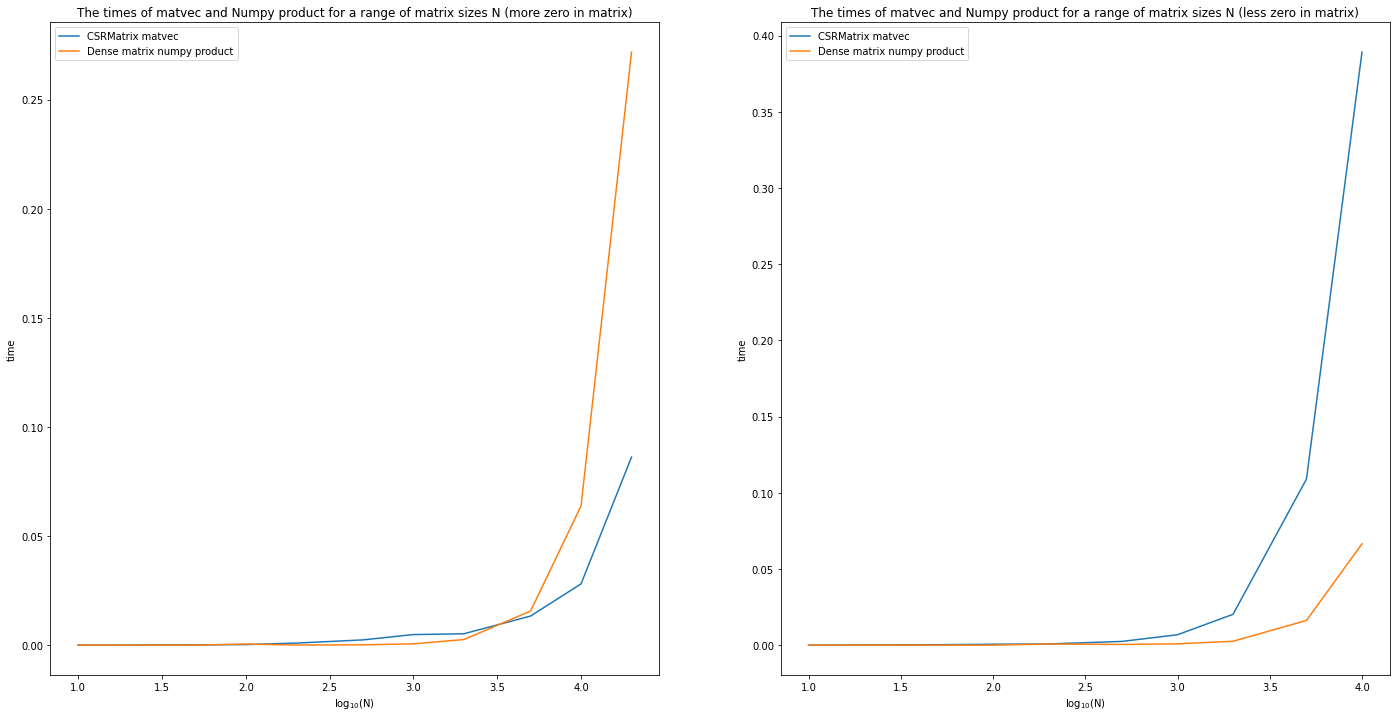

In [ ]:
# create a plot showing the times of matvec and Numpy for a range of matrix sizes

N = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
sparse_matvec_time_arr = []
sparse_numpy_product_time_arr = []
dense_matvec_time_arr = []
dense_numpy_product_time_arr = []
for n in N:
    x = rand.randn(n)
    coo_diagonal_sparse = my_diagonal_matrix(1, n)
    my_csr_diagonal_sparse = CSRMatrix(coo_diagonal_sparse)
    numpy_dense_diagonal_sparse = np.array(coo_diagonal_sparse.todense())
    start = time.time()
    my_csr_diagonal_sparse.matvec(x)
    end = time.time()
    sparse_matvec_time_arr.append(end - start)
    start = time.time()
    numpy_dense_diagonal_sparse.dot(x)
    end = time.time()
    sparse_numpy_product_time_arr.append(end - start)

plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
plt.plot(np.log10(N), sparse_matvec_time_arr, label='CSRMatrix matvec')
plt.plot(np.log10(N), sparse_numpy_product_time_arr, label='Dense matrix numpy product')
plt.legend()
plt.title("The times of matvec and Numpy product for a range of matrix sizes N (more zero in matrix)")
plt.xlabel('$\\log_{10}$(N)')
plt.ylabel('time')

for n in N[0:-1]:
    x = rand.randn(n)
    coo_diagonal_dense = my_diagonal_matrix(int(n * 0.6), n)
    my_csr_diagonal_dense = CSRMatrix(coo_diagonal_dense)
    numpy_dense_diagonal_dense = np.array(coo_diagonal_dense.todense())
    start = time.time()
    my_csr_diagonal_dense.matvec(x)
    end = time.time()
    dense_matvec_time_arr.append(end - start)
    start = time.time()
    numpy_dense_diagonal_dense.dot(x)
    end = time.time()
    dense_numpy_product_time_arr.append(end - start)

plt.subplot(1, 2, 2)
plt.plot(np.log10(N[0:-1]), dense_matvec_time_arr, label='CSRMatrix matvec')
plt.plot(np.log10(N[0:-1]), dense_numpy_product_time_arr, label='Dense matrix numpy product')
plt.legend()
plt.title("The times of matvec and Numpy product for a range of matrix sizes N (less zero in matrix)")
plt.xlabel('$\\log_{10}$(N)')
plt.ylabel('time')
plt.show()

By looking at the left figure, we can see that when N is small (N<2000), the time taken by the two methods is similar, and sometimes the dense matrix numpy product method is a little bit faster (but this is not absolute, when I make a few more runs to get similar plots, sometimes CSRMatrix matvec is faster). In the figure of this experiment, when N gradually becomes larger, especially when N>5000, the time spent by the dense matrix numpy product method and the time spent by the CSRMatrix matvec method start to appear a larger gap, and the gap becomes larger and larger. Observing the fold line trend of the figure, we can predict that when N>20000, the dense matrix numpy product method takes much more time than the other one. We can conclude that when the matrix is sparse (more zeros in the matrix), N is small, the speed difference between the two methods is not much and the time spent is similar. As N gradually increases, the CSRMatrix matvec method takes less time and is faster than the other one, and this trend is becoming more and more obvious.

By looking at the figure on the right, we can see that when N is small (N<2000), the time taken by the two methods is similar, with the dense matrix numpy product method being slightly faster. As N gradually increases, the dense matrix numpy product method takes less time and is faster than the CSRMatrix matvec method. When N becomes larger (N>10000), the difference is more obvious.
We can conclude that when the matrix is dense (less zeros in the matrix), for the range of matrix sizes N, the dense matrix numpy product method always outperforms the other one, and this trend becomes more and more obvious as N increases.

matrix is not positive definite
the solutions are not the same
matrix is positive definite
the solutions are the same


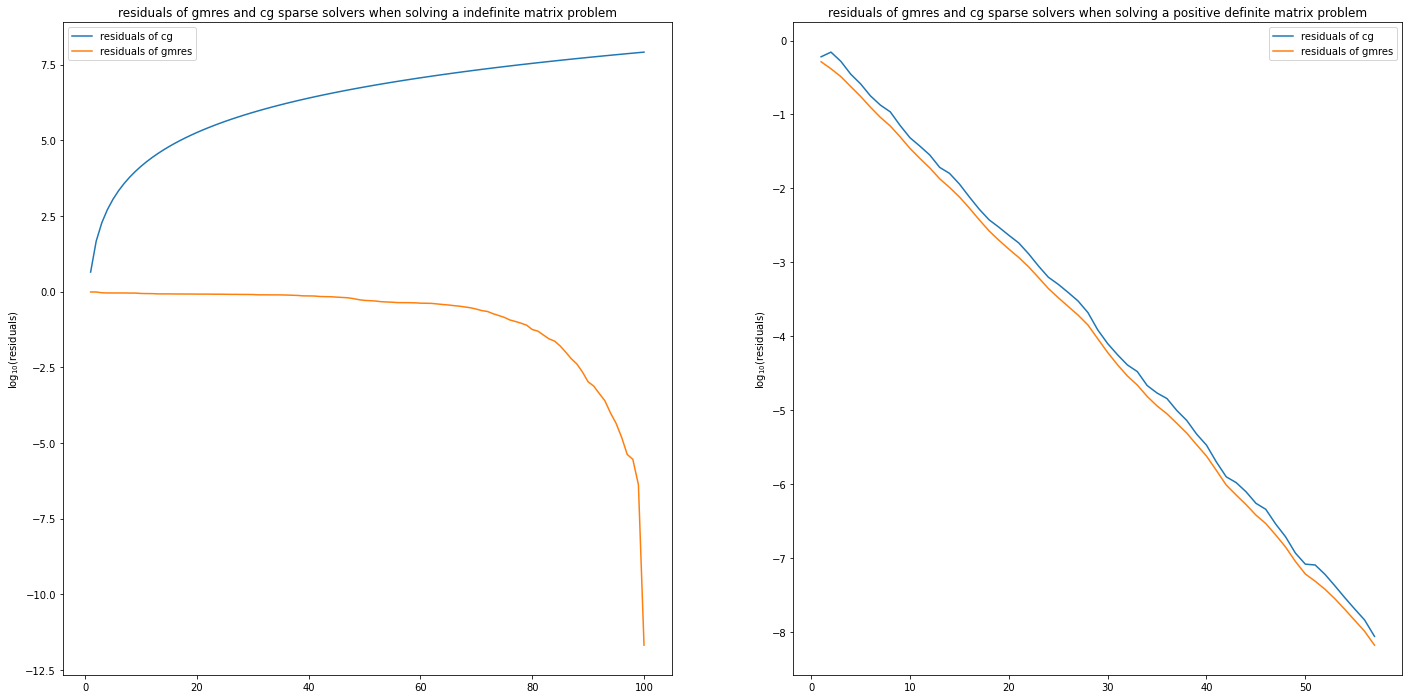

In [ ]:
# use Scipy’s gmres and cg sparse solvers to solve a matrix problem using my CSR matrix and check if the two solutions obtained are the same
test_N = 100
A = my_diagonal_matrix(10, test_N)
try:
    # check if the matrix is positive definite
    pdf_message = np.linalg.cholesky(A.todense())
    print("matrix is positive definite")
except np.linalg.LinAlgError:
    print("matrix is not positive definite")
my_csr_A = CSRMatrix(A)
b = rand.randn(test_N)
residuals_cg = []
residuals_gmres = []
callback_cg = lambda x: residuals_cg.append(np.linalg.norm(b - A @ x) / np.linalg.norm(b))
sol_cg, exitCode_cg = cg(my_csr_A, b, tol=1E-8, callback=callback_cg, maxiter=100)
callback = lambda res: residuals_gmres.append(res)
sol_gmres, exitCode_gmres = gmres(my_csr_A, b, tol=1E-8, restart=100, callback=callback, callback_type='pr_norm')
if np.allclose(sol_cg, sol_gmres):
    print("the solutions are the same")
else:
    print("the solutions are not the same")

plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
plt.title("residuals of gmres and cg sparse solvers when solving a indefinite matrix problem")
plt.ylabel('$\\log_{10}$(residuals)')
plt.plot(np.arange(1, len(residuals_cg) + 1), np.log10(residuals_cg), label='residuals of cg')
plt.plot(np.arange(1, len(residuals_gmres) + 1), np.log10(residuals_gmres), label='residuals of gmres')
plt.legend()

# define a positive definite matrix
data = [2.1 * np.ones(test_N), -1. * np.ones(test_N - 1), -1. * np.ones(test_N - 1)]
offsets = [0, 1, -1]
A = coo_matrix(diags(data, offsets=offsets, shape=(test_N, test_N), format='coo').todense())
try:
    pdf_message = np.linalg.cholesky(A.todense())
    print("matrix is positive definite")
except np.linalg.LinAlgError:
    print("matrix is not positive definite")
my_csr_A = CSRMatrix(A)
b = rand.randn(test_N)
residuals_cg = []
residuals_gmres = []
callback_cg = lambda x: residuals_cg.append(np.linalg.norm(b - A @ x) / np.linalg.norm(b))
sol_cg, exitCode_cg = cg(my_csr_A, b, tol=1E-8, callback=callback_cg, maxiter=100)
callback = lambda res: residuals_gmres.append(res)
sol_gmres, exitCode_gmres = gmres(my_csr_A, b, tol=1E-8, restart=100, callback=callback, callback_type='pr_norm')

if np.allclose(sol_cg, sol_gmres):
    print("the solutions are the same")
else:
    print("the solutions are not the same")

plt.subplot(1, 2, 2)
plt.title("residuals of gmres and cg sparse solvers when solving a positive definite matrix problem")
plt.ylabel('$\\log_{10}$(residuals)')
plt.plot(np.arange(1, len(residuals_cg) + 1), np.log10(residuals_cg), label='residuals of cg')
plt.plot(np.arange(1, len(residuals_gmres) + 1), np.log10(residuals_gmres), label='residuals of gmres')
plt.legend()
plt.show()

It can be concluded from my experimental results that when gmres and cg sparse solvers solve a indefinite matrix problem (the matrix is not positive definite), the two solutions obtained are not the same. When gmres and cg sparse solvers solve a positive definite matrix problem and the tolerance of convergence is small enough, the two solutions obtained are the same.

By looking at the left figure, we can see that the residuals obtained by cg solver increase with iteration when solving the non-positive definite matrix problem, which is contrary to the idea that the residuals need to decrease with iteration when solving this problem.  The residuals from gmres solver are decreasing with each iteration.  By looking at the figure on the right, we can see that the residuals from both solvers are decreasing with iteration when solving the positive definite matrix problem.  Therefore, we can conclude that cg sovler can only solve positive definite matrix problems, while gmres solver does not have this limitation.  When solving the positive definite matrix problem, the solutions of both solvers are exactly equal when the tolerance of convergence is small enough, and approximately equal when the tolerance of convergence is not small enough, because the better result is affected by the number of iterations, and the end of the iteration is affected by the tolerance of convergence.

Mathematically, the reason why the conjugate gradient method cannot solve the indefinte problem is:

For a matrix A, it essentially defaults to the fact that an inner product (x,y)→ $y^{T}Ax$. the conjugate gradient method computes a series of search directions which are A-orthogonal to each other, and when the matrix is not a positive definite matrix, your default fact is broken and you cannot find a vector $x^{T}Ax = 0$.

Generalized Minimal Residuals can keep the global residual gradually decreasing while not subject to this limitation.

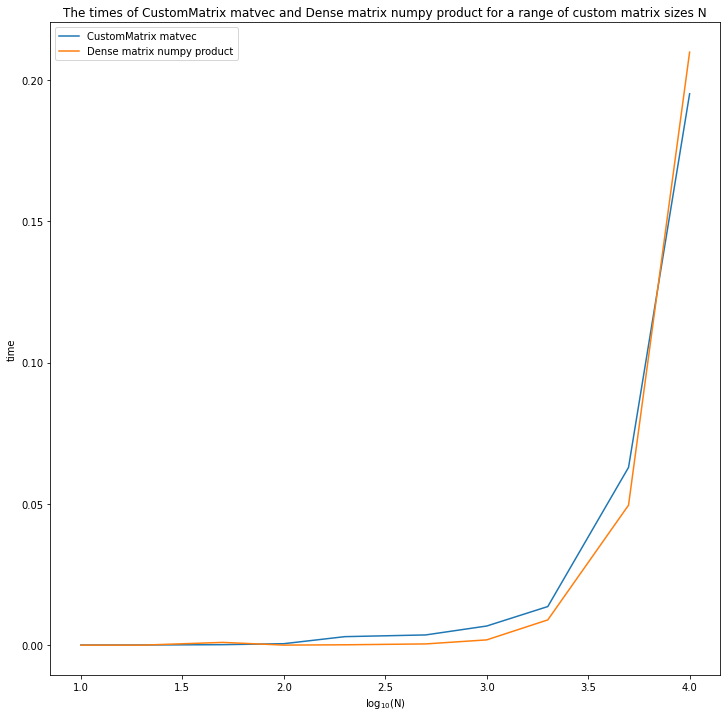

In [ ]:
# ----------  Part2  ----------


N = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
custom_matrix_matvec_time_arr = []
dense_matrix_product_time_arr = []
for n in N:
    # create my own CustomMatrix to represent matrix A
    A_diagonal = np.diag(rand.randn(n))
    T = rand.randn(n, 2)
    W = rand.randn(2, n)
    x = rand.randn(2 * n)
    A_custom_matrix = CustomMatrix(A_diagonal, T, W)
    # create the general numpy dense matrix to represent matrix A
    A_bottom_right = T @ W
    zero_array = np.zeros((n, n))
    top = np.hstack((A_diagonal, zero_array))
    bottom = np.hstack((zero_array, A_bottom_right))
    A_dense_matrix = np.vstack((top, bottom))
    start = time.time()
    result_custom_matrix = A_custom_matrix.matvec(x)
    end = time.time()
    custom_matrix_matvec_time_arr.append(end - start)
    start = time.time()
    result_dense_matrix = A_dense_matrix.dot(x)
    end = time.time()
    dense_matrix_product_time_arr.append(end - start)
    # check the result
    assert np.allclose(result_custom_matrix, result_dense_matrix) == True, 'Results are not equal, wrong matvec implementation.'

plt.figure(figsize=(12, 12))
plt.plot(np.log10(N), custom_matrix_matvec_time_arr, label='CustomMatrix matvec')
plt.plot(np.log10(N), dense_matrix_product_time_arr, label='Dense matrix numpy product')
plt.legend()
plt.title("The times of CustomMatrix matvec and Dense matrix numpy product for a range of custom matrix sizes N")
plt.xlabel('$\\log_{10}$(N)')
plt.ylabel('time')
plt.show()

Similar to the two methods compared to Part1, in this experiment, the two methods of matrix-vector products compared are the matvec method in the CustomMatrix class I defined (the role of this class is to store the matrix in a self-defined csr format) and the numpy product method of the matrix.

By analyzing the custom matrix Part 2 provides, if the dense and sparse of the matrix are judged by whether the number of zeros in the matrix is greater than or less than 50%, I find that its density still tends to be sparse. According to the previous conclusion, CustomMatrix matvec method tends to save more time than the dense matrxi numpy product when N becomes larger. By looking at the figures obtained in the experiment, it can be seen that when N belongs to the interval [10,5000], the custom matrix matvec method takes more time than the dense matrix numpy product method, but the difference is not obvious. When N belongs to the interval [5000,10000], the speed of the CustomMatrix matvec method overtakes the other one (view the time comparsion when N = 10000), and it takes less time than the other one, but the gap is still small, the CustomMatrix matvec method will take less time than the other method based on the trend of the fold line, but the difference may still not too significant.


Because the number of zeros in the matrix is only one factor that affects the matrix-vector product of the sparse matrix, when the density of the matrix becomes larger and becomes dense matrix, the speed of the sparse matrix is naturally greatly affected. By definition, sparse matrix can better replace "pseudo-dense matrix" with many 0 elements, not for the real dense matrix. Another factor is the placement of zeros, which I think may affect the memory allocation (consider an N*N matrix with N non-zero elements, matrix A puts all the non-zero elements in the first row, and matrix B puts all the non-zero elements in the diagonal of each row, the time cost of matvec method will be different). Therefore, for the custom matrix in this problem, its density should be between sparse and dense. Compared with the dense matrix numpy product method that calls memory in advance and uses C language as the bottom, even if my method is faster than the former, it is not much faster.